In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import copy
import warnings
# import math
# from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
# from sklearn.preprocessing import label_binarize
# from scipy import interp
# from itertools import cycle, zip_longest, chain
# import pickle
# from MVDD.MVDD import MVDD
# import MVDD.MVDD_Generator as mvGen
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import model_comp as MC
from model_comp import getCalibrationCurve

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rc('font', size=12)
warnings.filterwarnings('ignore')

In [2]:
#Load ESCAPE training data
escapeAllData = pd.read_csv("../Data/Preprocessed Data/ESCAPE_AllData.csv", sep=",", index_col='ID').sort_index() #all feature dataset
escapeHemo = pd.read_csv("../Data/Preprocessed Data/ESCAPE_Hemo.csv", sep=",", index_col='ID').sort_index() #dataset with only hemodynamics
escapeLabels  = pd.read_csv("../Data/Original DataFrames/Labels.csv", sep=",", index_col='DEIDNUM').sort_index() #labels for prediction classes 
escapeHemoLabels = escapeLabels[escapeLabels.index.isin(escapeHemo.index)]

#Cardiogenic Shock
cardShockHemo = pd.read_csv("../Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_Hemo.csv", sep=",", index_col='ID').sort_index()
cardShockAllData = pd.read_csv("../Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_AllData.csv", sep=",", index_col='ID').sort_index()
cardShockHemoLabels = pd.read_csv("../Data Validation/Cardiogenic Shock/Original DataFrames/HemoLabelsCardiogenicShock.csv", sep=",", index_col='ID').sort_index()
cardShockLabels = pd.read_csv("../Data Validation/Cardiogenic Shock/Original DataFrames/LabelsCardiogenicShock.csv", sep=",", index_col='ID').sort_index()

#Serial Cardiac
serialHemo = pd.read_csv("../Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_Hemo.csv", sep=",", index_col='ID').sort_index()
serialAllData = pd.read_csv("../Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_AllData.csv", sep=",", index_col='ID').sort_index()
serialHemoLabels = pd.read_csv("../Data Validation/Serial Cardiac Caths/Original DataFrames/HemoLabelsSerialCardiac.csv", sep=",", index_col='ID').sort_index()
serialLabels = pd.read_csv("../Data Validation/Serial Cardiac Caths/Original DataFrames/LabelsSerialCardiac.csv", sep=",", index_col='ID').sort_index()

#BEST
bestAllData = pd.read_csv("../Data Validation/BEST/Preprocessed Data/BEST_AllData.csv", sep=",", index_col='ID').sort_index()
bestLabels = pd.read_csv("../Data Validation/BEST/Original DataFrames/LabelsBEST.csv", sep=",", index_col='ID').sort_index()

#Guide it
guideAllData = pd.read_csv("../Data Validation/GUIDE-IT/Preprocessed Data/GUIDE-IT_AllData.csv", sep=",", index_col='ID').sort_index()
guideLabels = pd.read_csv("../Data Validation/GUIDE-IT/Original DataFrames/LabelsGUIDE-IT.csv", sep=",", index_col='ID').sort_index()


# # Fix escape labels
escapeAllData.index = (escapeAllData.index.str.rstrip('x')).astype(int)
escapeAllData = escapeAllData.sort_index()

In [3]:
## Load Hemo Training Escape Data
#Load original dataframes
escHemo = pd.read_csv('../Data/Preprocessed Data/ESCAPE_Hemo.csv', index_col='ID')
escHemodeath = escHemo['ScoreDeath']
escHemorehosp = escHemo['ScoreRehosp']
escHemoreadm = escHemo['ScoreReadmission']

# Preprocess and create training and testing sets
escHemo = escHemo.drop('Score', axis=1)
escHemo = escHemo.drop('ScoreDeath', axis=1)
escHemo = escHemo.drop('ScoreRehosp', axis=1)
escHemo = escHemo.drop('ScoreReadmission', axis=1)
escHemo = escHemo.replace(np.inf, 0)
escHemo = escHemo.fillna(0)

In [4]:
## Load hemo validation
# card shock
cardShockHemo = pd.read_csv("../Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_Hemo.csv", sep=",", index_col='ID')
cardShockHemodeath = cardShockHemo['ScoreDeath']
cardShockHemorehosp = cardShockHemo['ScoreRehosp']

cardShockHemo = cardShockHemo.drop('ScoreDeath', axis=1)
cardShockHemo = cardShockHemo.drop('Score', axis=1)
cardShockHemo = cardShockHemo.drop('ScoreRehosp', axis=1)
cardShockHemo = cardShockHemo.drop('ScoreReadmission', axis=1)
cardShockHemo = cardShockHemo.replace(np.inf, 0)
cardShockHemo = cardShockHemo.fillna(0)

# serial cardiac
serialHemo = pd.read_csv("../Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_Hemo.csv", sep=",", index_col='ID')
serialHemodeath = serialHemo['ScoreDeath']
serialHemorehosp = serialHemo['ScoreRehosp']

serialHemo = serialHemo.drop('ScoreDeath', axis=1)
serialHemo = serialHemo.drop('Score', axis=1)
serialHemo = serialHemo.drop('ScoreRehosp', axis=1)
serialHemo = serialHemo.drop('ScoreReadmission', axis=1)
serialHemo = serialHemo.replace(np.inf, 0)
serialHemo = serialHemo.fillna(0)



In [5]:
## Load all data Training Escape Data
#Load original dataframes
escAllData = pd.read_csv('../Data/Preprocessed Data/ESCAPE_AllData.csv', index_col='ID')
escAllDatadeath = escAllData['ScoreDeath']
escAllDatarehosp = escAllData['ScoreRehosp']
escAllDatareadm = escAllData['ScoreReadmission']

# Preprocess and create training and testing sets
escAllData = escAllData.drop('Score', axis=1)
escAllData = escAllData.drop('ScoreDeath', axis=1)
escAllData = escAllData.drop('ScoreRehosp', axis=1)
escAllData = escAllData.drop('ScoreReadmission', axis=1)
escAllData = escAllData.replace(np.inf, 0)
escAllData = escAllData.fillna(0)


In [6]:
## Load all data validation
# card shock
cardShockAllData = pd.read_csv("../Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_AllData.csv", sep=",", index_col='ID')
cardShockAllDatadeath = cardShockAllData['ScoreDeath']
cardShockAllDatarehosp = cardShockAllData['ScoreRehosp']

cardShockAllData = cardShockAllData.drop('ScoreDeath', axis=1)
cardShockAllData = cardShockAllData.drop('Score', axis=1)
cardShockAllData = cardShockAllData.drop('ScoreRehosp', axis=1)
cardShockAllData = cardShockAllData.drop('ScoreReadmission', axis=1)
cardShockAllData = cardShockAllData.replace(np.inf, 0)
cardShockAllData = cardShockAllData.fillna(0)

# serial cardiac
serialAllData = pd.read_csv("../Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_AllData.csv", sep=",", index_col='ID')
serialAllDatadeath = serialAllData['ScoreDeath']
serialAllDatarehosp = serialAllData['ScoreRehosp']

serialAllData = serialAllData.drop('ScoreDeath', axis=1)
serialAllData = serialAllData.drop('Score', axis=1)
serialAllData = serialAllData.drop('ScoreRehosp', axis=1)
serialAllData = serialAllData.drop('ScoreReadmission', axis=1)
serialAllData = serialAllData.replace(np.inf, 0)
serialAllData= serialAllData.fillna(0)

#best
bestAllData = pd.read_csv("../Data Validation/BEST/Preprocessed Data/BEST_AllData.csv", sep=",", index_col='ID')
bestAllDatadeath = bestAllData['ScoreDeath']
bestAllDatarehosp = bestAllData['ScoreRehosp']

bestAllData = bestAllData.drop('ScoreDeath', axis=1)
bestAllData = bestAllData.drop('Score', axis=1)
bestAllData = bestAllData.drop('ScoreRehosp', axis=1)
bestAllData = bestAllData.drop('ScoreReadmission', axis=1)
bestAllData = bestAllData.replace(np.inf, 0)
bestAllData  = bestAllData.fillna(0)

#guide
guideAllData = pd.read_csv("../Data Validation/GUIDE-IT/Preprocessed Data/GUIDE-IT_AllData.csv", sep=",", index_col='ID')
guideAllDatadeath = guideAllData['ScoreDeath']
guideAllDatarehosp = guideAllData['ScoreDeath']

guideAllData = guideAllData.drop('ScoreDeath', axis=1)
guideAllData = guideAllData.drop('Score', axis=1)
guideAllData = guideAllData.drop('ScoreRehosp', axis=1)
guideAllData = guideAllData.drop('ScoreReadmission', axis=1)
guideAllData = guideAllData.replace(np.inf, 0)
guideAllData = guideAllData.fillna(0)

# Hemodynamics

## DeLvTx Outcome

In [7]:
xData = copy.deepcopy(escHemo)
yData = escHemodeath
xData.shape, yData.shape

# KNN
modelName = "KNN"
knn = KNeighborsClassifier()

knn, knn_train_mets = MC.trainCrossVal(xData, yData, model=knn, numFolds=5, modelName=modelName, showIndividualROC=False)
cs_knn_mets, cs_knn_pred = MC.performValidation(knn, cardShockHemo, cardShockHemodeath, modelName)
ser_knn_mets, ser_knn_pred = MC.performValidation(knn, serialHemo, serialHemodeath, modelName)

# DT
modelName = "DT"
dt = DecisionTreeClassifier(random_state=100, max_depth=None)

dt, dt_train_mets = MC.trainCrossVal(xData, yData, model=dt, numFolds=5, modelName=modelName, showIndividualROC=False)
cs_dt_mets, cs_dt_pred = MC.performValidation(dt, cardShockHemo, cardShockHemodeath, modelName)
ser_dt_mets, ser_dt_pred = MC.performValidation(dt, serialHemo, serialHemodeath, modelName)

# RF
modelName = "RF"
rf = RandomForestClassifier(random_state=100, n_estimators=1000)

rf, rf_train_mets = MC.trainCrossVal(xData, yData, model=rf, numFolds=5, modelName=modelName, showIndividualROC=False)
cs_rf_mets, cs_rf_pred = MC.performValidation(rf, cardShockHemo, cardShockHemodeath, modelName)
ser_rf_mets, ser_rf_pred = MC.performValidation(rf, serialHemo, serialHemodeath, modelName)


metLst = [knn_train_mets, cs_knn_mets, ser_knn_mets,
          dt_train_mets, cs_dt_mets, ser_dt_mets, 
          rf_train_mets, cs_rf_mets, ser_rf_mets]

# Make dataframe of stats
columns=["Model", "TPR", "TPR SD", "TPR CI", "TNR", "TNR SD", "TNR CI", "PPV", "PPV SD", "PPV CI",
             "NPV", "NPV SD", "NPV CI", "FPR", "FPR SD", "FPR CI", "FNR", "FNR SD", "FNR CI",
             "Acc", "Acc SD", "Acc CI", "AUC", "AUC SD", "AUC CI"]

mets = pd.DataFrame(metLst, columns=columns)
mets.index = ["Escape", "Card Shock", "Serial", "Escape", "Card Shock", "Serial", "Escape", "Card Shock", "Serial"]
mets.to_csv("Hemo_DeLvTx_Results.csv")
mets

,Model,TPR,TPR SD,TPR CI,TNR,TNR SD,TNR CI,PPV,PPV SD,PPV CI,...,FPR CI,FNR,FNR SD,FNR CI,Acc,Acc SD,Acc CI,AUC,AUC SD,AUC CI
Escape,KNN,0.587408,0.562030,0.040083,0.845064,0.296862,0.079640,0.587938,0.505723,0.040204,...,0.079640,0.412592,0.562030,0.040083,0.786621,0.334545,0.072583,0.716236,0.365651,0.063044
Card Shock,KNN,0.414569,0.436122,0.046620,0.702757,0.296255,0.071822,0.404219,0.167921,0.049364,...,0.071822,0.585431,0.436122,0.046620,0.587196,0.062203,0.047100,0.558663,0.084203,0.038632
Serial,KNN,0.453468,0.707625,0.025358,0.828251,0.362935,0.067350,0.424492,0.125148,0.032302,...,0.067350,0.546532,0.707625,0.025358,0.758993,0.387582,0.059824,0.640860,0.358032,0.044119
Escape,DT,0.937126,0.176952,0.089637,0.968279,0.088990,0.092776,0.939041,0.165684,0.089833,...,0.092776,0.062874,0.176952,0.089637,0.957935,0.108662,0.091745,0.952703,0.123478,0.091220
Card Shock,DT,0.922265,0.111876,0.103648,0.963441,0.055192,0.108584,0.916011,0.146571,0.102877,...,0.108584,0.077735,0.111876,0.103648,0.949227,0.071803,0.106906,0.942853,0.080822,0.106144
Serial,DT,0.948949,0.117126,0.078765,0.979367,0.039597,0.081389,0.722666,0.597356,0.055470,...,0.081389,0.051051,0.117126,0.078765,0.969065,0.059950,0.080510,0.964158,0.077017,0.080088
Escape,RF,0.953445,0.127271,0.091295,0.979320,0.059426,0.093863,0.951454,0.137032,0.091094,...,0.093863,0.046555,0.127271,0.091295,0.972266,0.068202,0.093170,0.966382,0.080574,0.092588
Card Shock,RF,0.920846,0.120808,0.103474,0.962270,0.061691,0.108446,0.912853,0.162314,0.102486,...,0.108446,0.079154,0.120808,0.103474,0.947020,0.074925,0.106643,0.941558,0.082965,0.105989
Serial,RF,0.960428,0.095185,0.079765,0.984012,0.030144,0.081783,0.733963,0.610919,0.056860,...,0.081783,0.039572,0.095185,0.079765,0.975540,0.044208,0.081064,0.972220,0.058459,0.080780


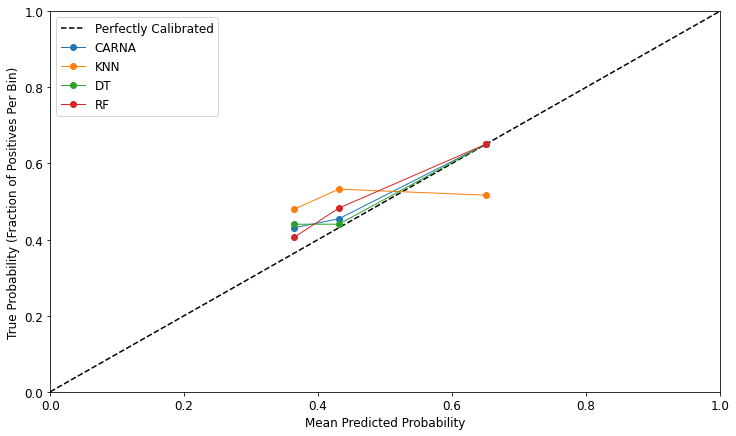

In [8]:
# Calibration Plot - Hemo Death - Card Shock

# gt_card = [0, 0, 0.45454545454545453, 0.6513761467889908, 0.43103448275862066]
gt_card = [0.041, 0.45454545454545453, 0.43103448275862066, 0.6513761467889908, 0.364]

n_bins = 10
binaryLabels = cardShockHemoLabels['Death']
scoreIdx = cardShockHemodeath.index
gt = gt_card
carna_y, carna_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=cardShockHemodeath, groundTruthProbs=gt)


knnScores = pd.DataFrame(cs_knn_pred, index=scoreIdx)
knn_y, knn_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=knnScores, groundTruthProbs=gt)

dtScores = pd.DataFrame(cs_dt_pred, index=scoreIdx)
dt_y, dt_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=dtScores, groundTruthProbs=gt)

rfScores = pd.DataFrame(cs_rf_pred, index=scoreIdx)
rf_y, rf_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=rfScores, groundTruthProbs=gt)


fig, ax = plt.subplots(figsize=(12,7))
line = mlines.Line2D([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly Calibrated')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

# only these two lines are calibration curves
plt.plot(carna_x, carna_y, marker='o', linewidth=1, label='CARNA')
plt.plot(knn_x, knn_y, marker='o', linewidth=1, label='KNN')
plt.plot(dt_x, dt_y, marker='o', linewidth=1, label='DT')
plt.plot(rf_x, rf_y, marker='o', linewidth=1, label='RF')

# plt.title('Calibration plot for Hemo - DeLvTx')
ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('True Probability (Fraction of Positives Per Bin)')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
plt.legend()

plt.savefig("Figures/Calibration_Hemo_DeLvTx_CardShock.png")
plt.show()

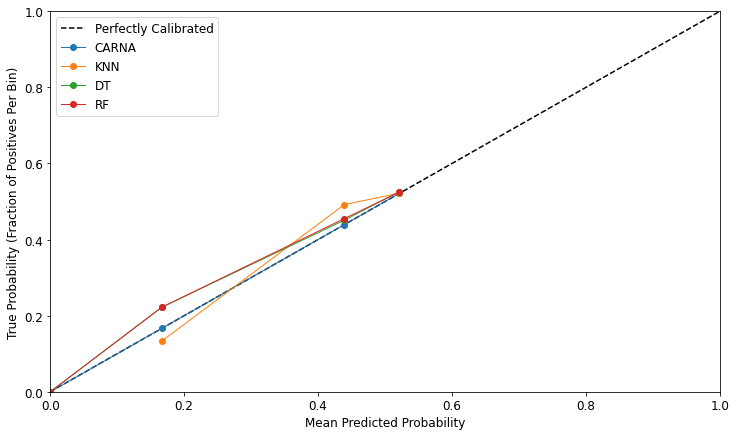

In [9]:
# Calibration Plot - Hemo Death - Serial

gt_serial = [0.16666666666666666, 0.0, 0.4391891891891892, 0.5246636771300448, 0.5168539325842697]

n_bins = 10
binaryLabels = serialHemoLabels['Death']
scoreIdx = serialHemodeath.index
gt = gt_serial
carna_y, carna_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=serialHemodeath, groundTruthProbs=gt)


knnScores = pd.DataFrame(ser_knn_pred, index=scoreIdx)
knn_y, knn_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=knnScores, groundTruthProbs=gt)

dtScores = pd.DataFrame(ser_dt_pred, index=scoreIdx)
dt_y, dt_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=dtScores, groundTruthProbs=gt)

rfScores = pd.DataFrame(ser_rf_pred, index=scoreIdx)
rf_y, rf_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=rfScores, groundTruthProbs=gt)


fig, ax = plt.subplots(figsize=(12,7))
line = mlines.Line2D([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly Calibrated')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

# only these two lines are calibration curves
plt.plot(carna_x, carna_y, marker='o', linewidth=1, label='CARNA')
plt.plot(knn_x, knn_y, marker='o', linewidth=1, label='KNN')
plt.plot(dt_x, dt_y, marker='o', linewidth=1, label='DT')
plt.plot(rf_x, rf_y, marker='o', linewidth=1, label='RF')

# plt.title('Calibration plot for Hemo - DeLvTx')
ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('True Probability (Fraction of Positives Per Bin)')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
plt.legend()

plt.savefig("Figures/Calibration_Hemo_DeLvTx_Serial.png")
plt.show()

## Rehosp Outcome

In [10]:
xData = copy.deepcopy(escHemo)
yData = escHemorehosp
xData.shape, yData.shape

# KNN
modelName = "KNN"
knn = KNeighborsClassifier()

knn, knn_train_mets = MC.trainCrossVal(xData, yData, model=knn, numFolds=5, modelName=modelName, showIndividualROC=False)
cs_knn_mets, cs_knn_pred = MC.performValidation(knn, cardShockHemo, cardShockHemorehosp, modelName)
ser_knn_mets, ser_knn_pred = MC.performValidation(knn, serialHemo, serialHemorehosp, modelName)

# DT
modelName = "DT"
dt = DecisionTreeClassifier(random_state=100, max_depth=None)

dt, dt_train_mets = MC.trainCrossVal(xData, yData, model=dt, numFolds=5, modelName=modelName, showIndividualROC=False)
cs_dt_mets, cs_dt_pred = MC.performValidation(dt, cardShockHemo, cardShockHemorehosp, modelName)
ser_dt_mets, ser_dt_pred = MC.performValidation(dt, serialHemo, serialHemorehosp, modelName)

# RF
modelName = "RF"
rf = RandomForestClassifier(random_state=100, n_estimators=1000)

rf, rf_train_mets = MC.trainCrossVal(xData, yData, model=rf, numFolds=5, modelName=modelName, showIndividualROC=False)
cs_rf_mets, cs_rf_pred = MC.performValidation(rf, cardShockHemo, cardShockHemorehosp, modelName)
ser_rf_mets, ser_rf_pred = MC.performValidation(rf, serialHemo, serialHemorehosp, modelName)


metLst = [knn_train_mets, cs_knn_mets, ser_knn_mets,
          dt_train_mets, cs_dt_mets, ser_dt_mets, 
          rf_train_mets, cs_rf_mets, ser_rf_mets]

# Make dataframe of stats
columns=["Model", "TPR", "TPR SD", "TPR CI", "TNR", "TNR SD", "TNR CI", "PPV", "PPV SD", "PPV CI",
             "NPV", "NPV SD", "NPV CI", "FPR", "FPR SD", "FPR CI", "FNR", "FNR SD", "FNR CI",
             "Acc", "Acc SD", "Acc CI", "AUC", "AUC SD", "AUC CI"]

mets = pd.DataFrame(metLst, columns=columns)
mets.index = ["Escape", "Card Shock", "Serial", "Escape", "Card Shock", "Serial", "Escape", "Card Shock", "Serial"]
mets.to_csv("Hemo_Rehosp_Results.csv")
mets

,Model,TPR,TPR SD,TPR CI,TNR,TNR SD,TNR CI,PPV,PPV SD,PPV CI,...,FPR CI,FNR,FNR SD,FNR CI,Acc,Acc SD,Acc CI,AUC,AUC SD,AUC CI
Escape,KNN,0.605662,0.546224,0.044070,0.853124,0.315579,0.080565,0.624353,0.460020,0.047809,...,0.080565,0.394338,0.546224,0.044070,0.800000,0.323429,0.074258,0.729393,0.344017,0.064934
Card Shock,KNN,0.426905,0.448044,0.043123,0.709141,0.245246,0.072944,0.393910,0.120969,0.051952,...,0.072944,0.573095,0.448044,0.043123,0.609272,0.028613,0.052726,0.568023,0.103943,0.041600
Serial,KNN,0.460874,0.711331,0.023252,0.830540,0.317060,0.067584,0.414070,0.069289,0.034459,...,0.067584,0.539126,0.711331,0.023252,0.763309,0.373073,0.060321,0.645707,0.358801,0.044872
Escape,DT,0.937126,0.176952,0.089637,0.968279,0.088990,0.092776,0.939041,0.165684,0.089833,...,0.092776,0.062874,0.176952,0.089637,0.957935,0.108662,0.091745,0.952703,0.123478,0.091220
Card Shock,DT,0.922265,0.111876,0.103648,0.963441,0.055192,0.108584,0.916011,0.146571,0.102877,...,0.108584,0.077735,0.111876,0.103648,0.949227,0.071803,0.106906,0.942853,0.080822,0.106144
Serial,DT,0.948949,0.117126,0.078765,0.979367,0.039597,0.081389,0.722666,0.597356,0.055470,...,0.081389,0.051051,0.117126,0.078765,0.969065,0.059950,0.080510,0.964158,0.077017,0.080088
Escape,RF,0.953445,0.127271,0.091295,0.979320,0.059426,0.093863,0.951454,0.137032,0.091094,...,0.093863,0.046555,0.127271,0.091295,0.972266,0.068202,0.093170,0.966382,0.080574,0.092588
Card Shock,RF,0.920846,0.120808,0.103474,0.962270,0.061691,0.108446,0.912853,0.162314,0.102486,...,0.108446,0.079154,0.120808,0.103474,0.947020,0.074925,0.106643,0.941558,0.082965,0.105989
Serial,RF,0.960428,0.095185,0.079765,0.984012,0.030144,0.081783,0.733963,0.610919,0.056860,...,0.081783,0.039572,0.095185,0.079765,0.975540,0.044208,0.081064,0.972220,0.058459,0.080780


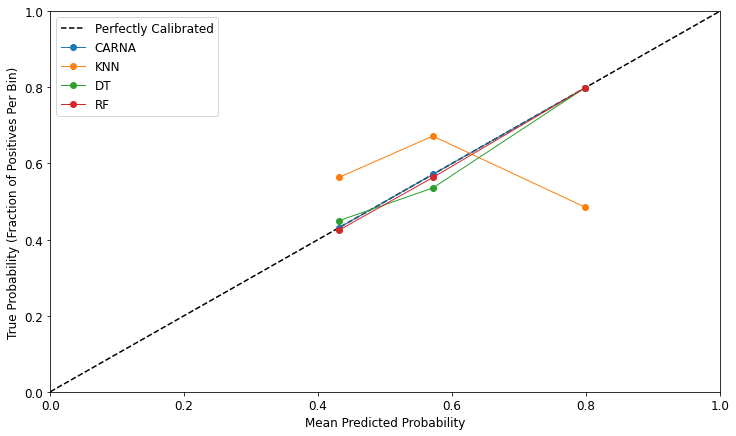

In [11]:
# Calibration Plot - Hemo Rehosp - Card Shock

gt_card = [0, 0, 0.43103448275862066, 0.5714285714285714, 0.7981651376146789]

n_bins = 10
binaryLabels = cardShockHemoLabels['Rehosp']
scoreIdx = cardShockHemorehosp.index
gt = gt_card
carna_y, carna_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=cardShockHemorehosp, groundTruthProbs=gt)


knnScores = pd.DataFrame(cs_knn_pred, index=scoreIdx)
knn_y, knn_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=knnScores, groundTruthProbs=gt)

dtScores = pd.DataFrame(cs_dt_pred, index=scoreIdx)
dt_y, dt_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=dtScores, groundTruthProbs=gt)

rfScores = pd.DataFrame(cs_rf_pred, index=scoreIdx)
rf_y, rf_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=rfScores, groundTruthProbs=gt)


fig, ax = plt.subplots(figsize=(12,7))
line = mlines.Line2D([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly Calibrated')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

# only these two lines are calibration curves
plt.plot(carna_x, carna_y, marker='o', linewidth=1, label='CARNA')
plt.plot(knn_x, knn_y, marker='o', linewidth=1, label='KNN')
plt.plot(dt_x, dt_y, marker='o', linewidth=1, label='DT')
plt.plot(rf_x, rf_y, marker='o', linewidth=1, label='RF')

# plt.title('Calibration plot for Hemo - DeLvTx')
ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('True Probability (Fraction of Positives Per Bin)')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
plt.legend()

plt.savefig("Figures/Calibration_Hemo_Rehosp_CardShock.png")
plt.show()


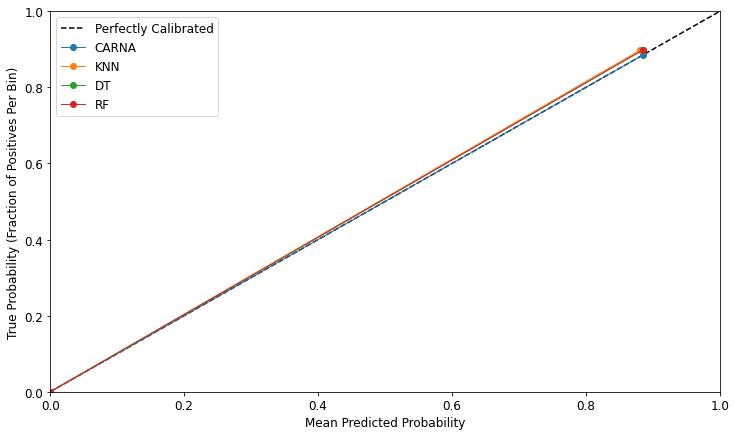

In [12]:
# Calibration Plot - Hemo Rehosp - Serial

gt_serial = [0.0, 0.0, 0.8876404494382022, 0.8716216216216216, 0.8923766816143498]

n_bins = 10
binaryLabels = serialHemoLabels['Rehosp']
scoreIdx = serialHemorehosp.index
gt = gt_serial
carna_y, carna_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=serialHemorehosp, groundTruthProbs=gt)


knnScores = pd.DataFrame(ser_knn_pred, index=scoreIdx)
knn_y, knn_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=knnScores, groundTruthProbs=gt)

dtScores = pd.DataFrame(ser_dt_pred, index=scoreIdx)
dt_y, dt_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=dtScores, groundTruthProbs=gt)

rfScores = pd.DataFrame(ser_rf_pred, index=scoreIdx)
rf_y, rf_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=rfScores, groundTruthProbs=gt)


fig, ax = plt.subplots(figsize=(12,7))
line = mlines.Line2D([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly Calibrated')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

# only these two lines are calibration curves
plt.plot(carna_x, carna_y, marker='o', linewidth=1, label='CARNA')
plt.plot(knn_x, knn_y, marker='o', linewidth=1, label='KNN')
plt.plot(dt_x, dt_y, marker='o', linewidth=1, label='DT')
plt.plot(rf_x, rf_y, marker='o', linewidth=1, label='RF')

# plt.title('Calibration plot for Hemo - DeLvTx')
ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('True Probability (Fraction of Positives Per Bin)')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
plt.legend()

plt.savefig("Figures/Calibration_Hemo_Rehosp_Serial.png")
plt.show()

## Readmission Outcome

In [13]:
xData = copy.deepcopy(escHemo)
yData = escHemoreadm
xData.shape, yData.shape

# KNN
modelName = "KNN"
knn = KNeighborsClassifier()
knn, knn_train_mets = MC.trainCrossVal(xData, yData, model=knn, numFolds=5, modelName=modelName, showIndividualROC=False)

# DT
modelName = "DT"
dt = DecisionTreeClassifier(random_state=100, max_depth=None)
dt, dt_train_mets = MC.trainCrossVal(xData, yData, model=dt, numFolds=5, modelName=modelName, showIndividualROC=False)

# RF
modelName = "RF"
rf = RandomForestClassifier(random_state=100, n_estimators=1000)
rf, rf_train_mets = MC.trainCrossVal(xData, yData, model=rf, numFolds=5, modelName=modelName, showIndividualROC=False)


metLst = [knn_train_mets, dt_train_mets, rf_train_mets]

# Make dataframe of stats
columns=["Model", "TPR", "TPR SD", "TPR CI", "TNR", "TNR SD", "TNR CI", "PPV", "PPV SD", "PPV CI",
             "NPV", "NPV SD", "NPV CI", "FPR", "FPR SD", "FPR CI", "FNR", "FNR SD", "FNR CI",
             "Acc", "Acc SD", "Acc CI", "AUC", "AUC SD", "AUC CI"]

mets = pd.DataFrame(metLst, columns=columns)
mets.index = ["Escape",  "Escape", "Escape"]
mets.to_csv("Hemo_Readm_Results.csv")
mets

,Model,TPR,TPR SD,TPR CI,TNR,TNR SD,TNR CI,PPV,PPV SD,PPV CI,...,FPR CI,FNR,FNR SD,FNR CI,Acc,Acc SD,Acc CI,AUC,AUC SD,AUC CI
Escape,KNN,0.587408,0.562030,0.040083,0.845064,0.296862,0.079640,0.587938,0.505723,0.040204,...,0.079640,0.412592,0.562030,0.040083,0.786621,0.334545,0.072583,0.716236,0.365651,0.063044
Escape,DT,0.937126,0.176952,0.089637,0.968279,0.088990,0.092776,0.939041,0.165684,0.089833,...,0.092776,0.062874,0.176952,0.089637,0.957935,0.108662,0.091745,0.952703,0.123478,0.091220
Escape,RF,0.953445,0.127271,0.091295,0.979320,0.059426,0.093863,0.951454,0.137032,0.091094,...,0.093863,0.046555,0.127271,0.091295,0.972266,0.068202,0.093170,0.966382,0.080574,0.092588


# All Data

## DeLvTx Outcome

In [14]:
xData = copy.deepcopy(escAllData)
yData = escAllDatadeath
xData.shape, yData.shape

# KNN
modelName = "KNN"
knn = KNeighborsClassifier()

knn, knn_train_mets = MC.trainCrossVal(xData, yData, model=knn, numFolds=5, modelName=modelName, showIndividualROC=False)
cs_knn_mets, cs_knn_pred = MC.performValidation(knn, cardShockAllData, cardShockAllDatadeath, modelName)
ser_knn_mets, ser_knn_pred = MC.performValidation(knn, serialAllData, serialAllDatadeath, modelName)
best_knn_mets, best_knn_pred = MC.performValidation(knn, bestAllData, bestAllDatadeath, modelName)
guide_knn_mets, guide_knn_pred = MC.performValidation(knn, guideAllData, guideAllDatadeath, modelName)


# DT
modelName = "DT"
dt = DecisionTreeClassifier(random_state=100, max_depth=None)

dt, dt_train_mets = MC.trainCrossVal(xData, yData, model=dt, numFolds=5, modelName=modelName, showIndividualROC=False)
cs_dt_mets, cs_dt_pred = MC.performValidation(dt, cardShockAllData, cardShockAllDatadeath, modelName)
ser_dt_mets, ser_dt_pred = MC.performValidation(dt, serialAllData, serialAllDatadeath, modelName)
best_dt_mets, best_dt_pred = MC.performValidation(dt, bestAllData, bestAllDatadeath, modelName)
guide_dt_mets, guide_dt_pred = MC.performValidation(dt, guideAllData, guideAllDatadeath, modelName)

# RF
modelName = "RF"
rf = RandomForestClassifier(random_state=100, n_estimators=1000)

rf, rf_train_mets = MC.trainCrossVal(xData, yData, model=rf, numFolds=5, modelName=modelName, showIndividualROC=False)
cs_rf_mets, cs_rf_pred = MC.performValidation(rf, cardShockAllData, cardShockAllDatadeath, modelName)
ser_rf_mets, ser_rf_pred = MC.performValidation(rf, serialAllData, serialAllDatadeath, modelName)
best_rf_mets, best_rf_pred = MC.performValidation(rf, bestAllData, bestAllDatadeath, modelName)
guide_rf_mets, guide_rf_pred = MC.performValidation(rf, guideAllData, guideAllDatadeath, modelName)


metLst = [knn_train_mets, cs_knn_mets, ser_knn_mets, best_knn_mets, guide_knn_mets,
          dt_train_mets, cs_dt_mets, ser_dt_mets, best_dt_mets, guide_dt_mets,
          rf_train_mets, cs_rf_mets, ser_rf_mets, best_rf_mets, guide_rf_mets]

# Make dataframe of stats
columns=["Model", "TPR", "TPR SD", "TPR CI", "TNR", "TNR SD", "TNR CI", "PPV", "PPV SD", "PPV CI",
             "NPV", "NPV SD", "NPV CI", "FPR", "FPR SD", "FPR CI", "FNR", "FNR SD", "FNR CI",
             "Acc", "Acc SD", "Acc CI", "AUC", "AUC SD", "AUC CI"]

mets = pd.DataFrame(metLst, columns=columns)
mets.index = ["Escape", "Card Shock", "Serial", "Best", "Guide", 
              "Escape", "Card Shock", "Serial", "Best", "Guide",
              "Escape", "Card Shock", "Serial", "Best", "Guide"]
mets.to_csv("AllData_DeLvTx_Results.csv")
mets

,Model,TPR,TPR SD,TPR CI,TNR,TNR SD,TNR CI,PPV,PPV SD,PPV CI,...,FPR CI,FNR,FNR SD,FNR CI,Acc,Acc SD,Acc CI,AUC,AUC SD,AUC CI
Escape,KNN,0.459976,0.854248,0.018844,0.820903,0.596033,0.053358,0.562747,0.592467,0.023594,...,0.053358,0.540024,0.854248,0.018844,0.865136,0.293304,0.056917,0.632653,0.388200,0.034306
Card Shock,KNN,0.253482,0.734103,0.040495,0.848138,0.287684,0.048123,0.291188,0.521209,0.037270,...,0.048123,0.746518,0.734103,0.040495,0.733333,0.232143,0.039397,0.550810,0.383882,0.018385
Serial,KNN,0.253811,0.733908,0.055594,0.834926,0.393767,0.064844,0.317652,0.504920,0.047846,...,0.064844,0.746189,0.733908,0.055594,0.699346,0.350097,0.050026,0.544368,0.443838,0.023601
Best,KNN,0.492887,0.759719,0.004473,0.819590,0.686834,0.029985,0.586525,0.636439,0.015602,...,0.029985,0.507113,0.759719,0.004473,0.903479,0.225135,0.033692,0.656239,0.315867,0.020965
Guide,KNN,0.394128,0.667371,0.032129,0.819424,0.563583,0.055807,0.444069,0.290764,0.023353,...,0.055807,0.605872,0.667371,0.032129,0.705584,0.404085,0.044772,0.606776,0.200605,0.032266
Escape,DT,0.962260,0.178261,0.064041,0.993664,0.022101,0.066180,0.923021,0.298696,0.061262,...,0.066180,0.037740,0.178261,0.064041,0.992606,0.018353,0.066109,0.977687,0.091280,0.065100
Card Shock,DT,0.798411,0.768472,0.044554,0.925637,0.265163,0.053211,0.782994,0.781856,0.043388,...,0.053211,0.201589,0.768472,0.044554,0.854892,0.331779,0.048588,0.862024,0.367742,0.049074
Serial,DT,0.789261,0.742901,0.060262,0.915992,0.283893,0.072267,0.760295,0.765937,0.057165,...,0.072267,0.210739,0.742901,0.060262,0.836601,0.357045,0.065006,0.852627,0.350309,0.066535
Best,DT,0.996005,0.014567,0.037355,0.999477,0.001303,0.037486,0.989189,0.042762,0.037098,...,0.037486,0.003995,0.014567,0.037355,0.999414,0.001435,0.037484,0.997741,0.007647,0.037421
Guide,DT,0.967426,0.110703,0.067509,0.998252,0.004359,0.069700,0.967877,0.111039,0.067542,...,0.069700,0.032574,0.110703,0.067509,0.997462,0.002780,0.069645,0.982839,0.055066,0.068613


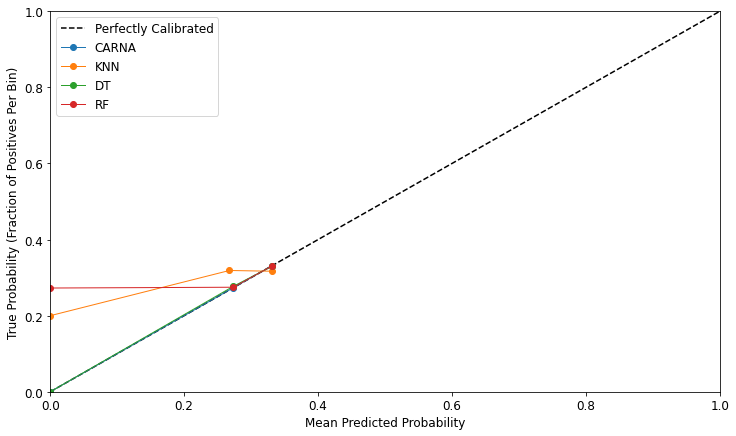

In [15]:
# Calibration Plot - All Data Death - BEST

gt_best = [0.33074684772065954, 0.3333333333333333, 0.27483443708609273, 0.0, 0.25925925925925924]

n_bins = 10
binaryLabels = bestLabels['Death']
scoreIdx = bestAllDatadeath.index
gt = gt_best
carna_y, carna_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=bestAllDatadeath, groundTruthProbs=gt)


knnScores = pd.DataFrame(best_knn_pred, index=scoreIdx)
knn_y, knn_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=knnScores, groundTruthProbs=gt)

dtScores = pd.DataFrame(best_dt_pred, index=scoreIdx)
dt_y, dt_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=dtScores, groundTruthProbs=gt)

rfScores = pd.DataFrame(best_rf_pred, index=scoreIdx)
rf_y, rf_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=rfScores, groundTruthProbs=gt)


fig, ax = plt.subplots(figsize=(12,7))
line = mlines.Line2D([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly Calibrated')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

# only these two lines are calibration curves
plt.plot(carna_x, carna_y, marker='o', linewidth=1, label='CARNA')
plt.plot(knn_x, knn_y, marker='o', linewidth=1, label='KNN')
plt.plot(dt_x, dt_y, marker='o', linewidth=1, label='DT')
plt.plot(rf_x, rf_y, marker='o', linewidth=1, label='RF')

# plt.title('Calibration plot for Hemo - DeLvTx')
ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('True Probability (Fraction of Positives Per Bin)')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
plt.legend()

plt.savefig("Figures/Calibration_AllData_DeLvTx_Best.png")
plt.show()

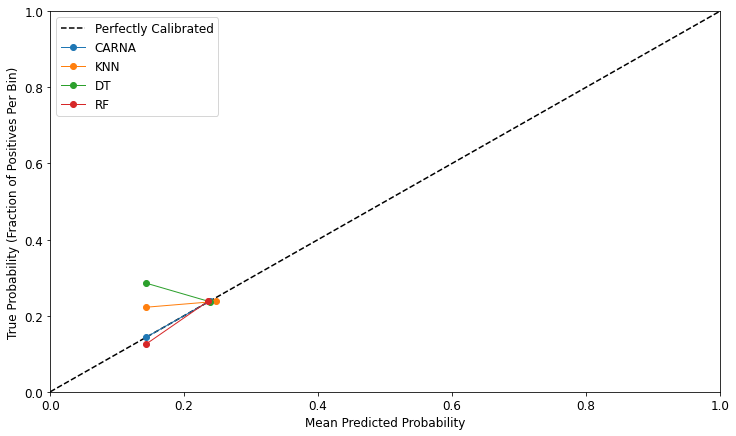

In [16]:
# Calibration Plot - All Data Death - Guide

gt_guide = [0.2517985611510791, 0.23504273504273504, 0.23843416370106763, 0.2283464566929134, 0.14285714285714285]

n_bins = 10
binaryLabels = guideLabels['Death']
scoreIdx = guideAllDatadeath.index
gt = gt_guide
carna_y, carna_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=guideAllDatadeath, groundTruthProbs=gt)


knnScores = pd.DataFrame(guide_knn_pred, index=scoreIdx)
knn_y, knn_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=knnScores, groundTruthProbs=gt)

dtScores = pd.DataFrame(guide_dt_pred, index=scoreIdx)
dt_y, dt_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=dtScores, groundTruthProbs=gt)

rfScores = pd.DataFrame(guide_rf_pred, index=scoreIdx)
rf_y, rf_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=rfScores, groundTruthProbs=gt)


fig, ax = plt.subplots(figsize=(12,7))
line = mlines.Line2D([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly Calibrated')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

# only these two lines are calibration curves
plt.plot(carna_x, carna_y, marker='o', linewidth=1, label='CARNA')
plt.plot(knn_x, knn_y, marker='o', linewidth=1, label='KNN')
plt.plot(dt_x, dt_y, marker='o', linewidth=1, label='DT')
plt.plot(rf_x, rf_y, marker='o', linewidth=1, label='RF')

# plt.title('Calibration plot for Hemo - DeLvTx')
ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('True Probability (Fraction of Positives Per Bin)')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
plt.legend()

plt.savefig("Figures/Calibration_AllData_DeLvTx_Guide.png")
plt.show()

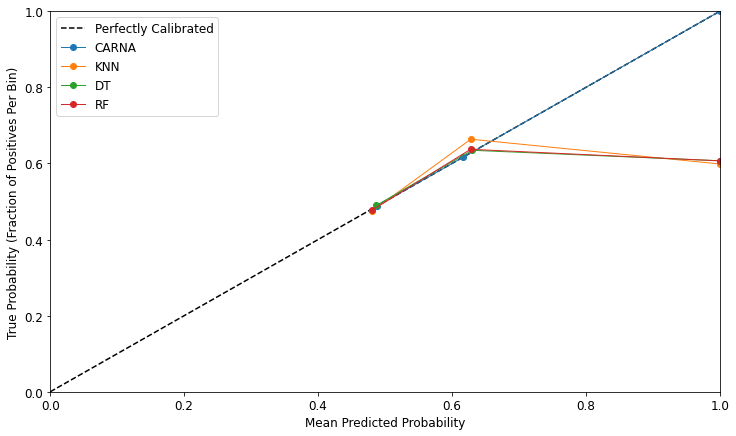

In [17]:
# Calibration Plot - All Data Death - Card Shock

gt_card = [1.0, 0.5, 0.6309523809523809, 0.48125, 0.607981220657277]

n_bins = 10
binaryLabels = cardShockLabels['Death']
scoreIdx = cardShockAllDatadeath.index
gt = gt_card
carna_y, carna_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=cardShockAllDatadeath, groundTruthProbs=gt)


knnScores = pd.DataFrame(cs_knn_pred, index=scoreIdx)
knn_y, knn_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=knnScores, groundTruthProbs=gt)

dtScores = pd.DataFrame(cs_dt_pred, index=scoreIdx)
dt_y, dt_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=dtScores, groundTruthProbs=gt)

rfScores = pd.DataFrame(cs_rf_pred, index=scoreIdx)
rf_y, rf_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=rfScores, groundTruthProbs=gt)


fig, ax = plt.subplots(figsize=(12,7))
line = mlines.Line2D([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly Calibrated')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

# only these two lines are calibration curves
plt.plot(carna_x, carna_y, marker='o', linewidth=1, label='CARNA')
plt.plot(knn_x, knn_y, marker='o', linewidth=1, label='KNN')
plt.plot(dt_x, dt_y, marker='o', linewidth=1, label='DT')
plt.plot(rf_x, rf_y, marker='o', linewidth=1, label='RF')

# plt.title('Calibration plot for Hemo - DeLvTx')
ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('True Probability (Fraction of Positives Per Bin)')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
plt.legend()

plt.savefig("Figures/Calibration_AllData_DeLvTx_CardShock.png")
plt.show()

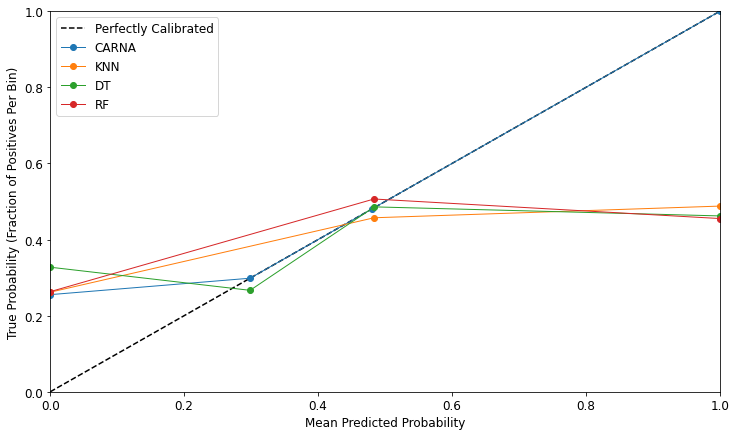

In [18]:
# Calibration Plot - All Data Death - Serial

gt_serial = [1.0, 0.29850746268656714, 0.4845360824742268, 0.0, 0.4765625]

n_bins = 10
binaryLabels = serialLabels['Death']
scoreIdx = serialAllDatadeath.index
gt = gt_serial
carna_y, carna_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=serialAllDatadeath, groundTruthProbs=gt)


knnScores = pd.DataFrame(ser_knn_pred, index=scoreIdx)
knn_y, knn_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=knnScores, groundTruthProbs=gt)

dtScores = pd.DataFrame(ser_dt_pred, index=scoreIdx)
dt_y, dt_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=dtScores, groundTruthProbs=gt)

rfScores = pd.DataFrame(ser_rf_pred, index=scoreIdx)
rf_y, rf_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=rfScores, groundTruthProbs=gt)


fig, ax = plt.subplots(figsize=(12,7))
line = mlines.Line2D([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly Calibrated')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

# only these two lines are calibration curves
plt.plot(carna_x, carna_y, marker='o', linewidth=1, label='CARNA')
plt.plot(knn_x, knn_y, marker='o', linewidth=1, label='KNN')
plt.plot(dt_x, dt_y, marker='o', linewidth=1, label='DT')
plt.plot(rf_x, rf_y, marker='o', linewidth=1, label='RF')

# plt.title('Calibration plot for Hemo - DeLvTx')
ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('True Probability (Fraction of Positives Per Bin)')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
plt.legend()

plt.savefig("Figures/Calibration_AllData_DeLvTx_Serial.png")
plt.show()

## Rehosp Outcome

In [19]:
xData = copy.deepcopy(escAllData)
yData = escAllDatarehosp
xData.shape, yData.shape

# KNN
modelName = "KNN"
knn = KNeighborsClassifier()

knn, knn_train_mets = MC.trainCrossVal(xData, yData, model=knn, numFolds=5, modelName=modelName, showIndividualROC=False)
cs_knn_mets, cs_knn_pred = MC.performValidation(knn, cardShockAllData, cardShockAllDatarehosp, modelName)
ser_knn_mets, ser_knn_pred = MC.performValidation(knn, serialAllData, serialAllDatarehosp, modelName)
best_knn_mets, best_knn_pred = MC.performValidation(knn, bestAllData, bestAllDatarehosp, modelName)
guide_knn_mets, guide_knn_pred = MC.performValidation(knn, guideAllData, guideAllDatarehosp, modelName)


# DT
modelName = "DT"
dt = DecisionTreeClassifier(random_state=100, max_depth=None)

dt, dt_train_mets = MC.trainCrossVal(xData, yData, model=dt, numFolds=5, modelName=modelName, showIndividualROC=False)
cs_dt_mets, cs_dt_pred = MC.performValidation(dt, cardShockAllData, cardShockAllDatarehosp, modelName)
ser_dt_mets, ser_dt_pred = MC.performValidation(dt, serialAllData, serialAllDatarehosp, modelName)
best_dt_mets, best_dt_pred = MC.performValidation(dt, bestAllData, bestAllDatarehosp, modelName)
guide_dt_mets, guide_dt_pred = MC.performValidation(dt, guideAllData, guideAllDatarehosp, modelName)

# RF
modelName = "RF"
rf = RandomForestClassifier(random_state=100, n_estimators=1000)

rf, rf_train_mets = MC.trainCrossVal(xData, yData, model=rf, numFolds=5, modelName=modelName, showIndividualROC=False)
cs_rf_mets, cs_rf_pred = MC.performValidation(rf, cardShockAllData, cardShockAllDatarehosp, modelName)
ser_rf_mets, ser_rf_pred = MC.performValidation(rf, serialAllData, serialAllDatarehosp, modelName)
best_rf_mets, best_rf_pred = MC.performValidation(rf, bestAllData, bestAllDatarehosp, modelName)
guide_rf_mets, guide_rf_pred = MC.performValidation(rf, guideAllData, guideAllDatarehosp, modelName)


metLst = [knn_train_mets, cs_knn_mets, ser_knn_mets, best_knn_mets, guide_knn_mets,
          dt_train_mets, cs_dt_mets, ser_dt_mets, best_dt_mets, guide_dt_mets,
          rf_train_mets, cs_rf_mets, ser_rf_mets, best_rf_mets, guide_rf_mets]

# Make dataframe of stats
columns=["Model", "TPR", "TPR SD", "TPR CI", "TNR", "TNR SD", "TNR CI", "PPV", "PPV SD", "PPV CI",
             "NPV", "NPV SD", "NPV CI", "FPR", "FPR SD", "FPR CI", "FNR", "FNR SD", "FNR CI",
             "Acc", "Acc SD", "Acc CI", "AUC", "AUC SD", "AUC CI"]

mets = pd.DataFrame(metLst, columns=columns)
mets.index = ["Escape", "Card Shock", "Serial", "Best", "Guide", 
              "Escape", "Card Shock", "Serial", "Best", "Guide",
              "Escape", "Card Shock", "Serial", "Best", "Guide"]
mets.to_csv("AllData_Rehosp_Results.csv")
mets

,Model,TPR,TPR SD,TPR CI,TNR,TNR SD,TNR CI,PPV,PPV SD,PPV CI,...,FPR CI,FNR,FNR SD,FNR CI,Acc,Acc SD,Acc CI,AUC,AUC SD,AUC CI
Escape,KNN,0.459976,0.854248,0.018844,0.820903,0.596033,0.053358,0.562747,0.592467,0.023594,...,0.053358,0.540024,0.854248,0.018844,0.865136,0.293304,0.056917,0.632653,0.388200,0.034306
Card Shock,KNN,0.253482,0.734103,0.040495,0.848138,0.287684,0.048123,0.291188,0.521209,0.037270,...,0.048123,0.746518,0.734103,0.040495,0.733333,0.232143,0.039397,0.550810,0.383882,0.018385
Serial,KNN,0.253811,0.733908,0.055594,0.834926,0.393767,0.064844,0.317652,0.504920,0.047846,...,0.064844,0.746189,0.733908,0.055594,0.699346,0.350097,0.050026,0.544368,0.443838,0.023601
Best,KNN,0.470665,0.808050,0.009085,0.819517,0.686758,0.029982,0.474824,0.558862,0.008416,...,0.029982,0.529335,0.808050,0.009085,0.903332,0.224890,0.033685,0.645091,0.332665,0.020204
Guide,KNN,0.301670,0.729530,0.043975,0.806831,0.530718,0.054696,0.241516,0.380886,0.050202,...,0.054696,0.698330,0.729530,0.043975,0.731980,0.315944,0.047559,0.554251,0.255327,0.022999
Escape,DT,0.962260,0.178261,0.064041,0.993664,0.022101,0.066180,0.923021,0.298696,0.061262,...,0.066180,0.037740,0.178261,0.064041,0.992606,0.018353,0.066109,0.977687,0.091280,0.065100
Card Shock,DT,0.798411,0.768472,0.044554,0.925637,0.265163,0.053211,0.782994,0.781856,0.043388,...,0.053211,0.201589,0.768472,0.044554,0.854892,0.331779,0.048588,0.862024,0.367742,0.049074
Serial,DT,0.789261,0.742901,0.060262,0.915992,0.283893,0.072267,0.760295,0.765937,0.057165,...,0.072267,0.210739,0.742901,0.060262,0.836601,0.357045,0.065006,0.852627,0.350309,0.066535
Best,DT,0.996005,0.014567,0.037355,0.999477,0.001303,0.037486,0.989189,0.042762,0.037098,...,0.037486,0.003995,0.014567,0.037355,0.999414,0.001435,0.037484,0.997741,0.007647,0.037421
Guide,DT,0.368864,0.907265,0.035758,0.819844,0.329581,0.055844,0.371429,0.914286,0.035406,...,0.055844,0.631136,0.907265,0.035758,0.720305,0.472394,0.046347,0.594354,0.604488,0.030331


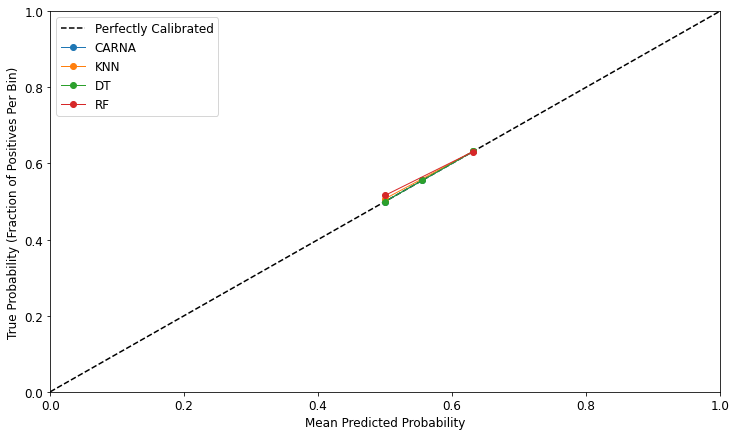

In [20]:
# Calibration Plot - All Data Rehosp - BEST

gt_best = [0.5, 0.5555555555555556, 0.6319107662463628, 0.6307947019867549, 0.5]

n_bins = 10
binaryLabels = bestLabels['Rehosp']
scoreIdx = bestAllDatarehosp.index
gt = gt_best
carna_y, carna_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=bestAllDatarehosp, groundTruthProbs=gt)


knnScores = pd.DataFrame(best_knn_pred, index=scoreIdx)
knn_y, knn_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=knnScores, groundTruthProbs=gt)

dtScores = pd.DataFrame(best_dt_pred, index=scoreIdx)
dt_y, dt_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=dtScores, groundTruthProbs=gt)

rfScores = pd.DataFrame(best_rf_pred, index=scoreIdx)
rf_y, rf_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=rfScores, groundTruthProbs=gt)


fig, ax = plt.subplots(figsize=(12,7))
line = mlines.Line2D([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly Calibrated')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

# only these two lines are calibration curves
plt.plot(carna_x, carna_y, marker='o', linewidth=1, label='CARNA')
plt.plot(knn_x, knn_y, marker='o', linewidth=1, label='KNN')
plt.plot(dt_x, dt_y, marker='o', linewidth=1, label='DT')
plt.plot(rf_x, rf_y, marker='o', linewidth=1, label='RF')

# plt.title('Calibration plot for Hemo - DeLvTx')
ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('True Probability (Fraction of Positives Per Bin)')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
plt.legend()

plt.savefig("Figures/Calibration_AllData_Rehosp_Best.png")
plt.show()

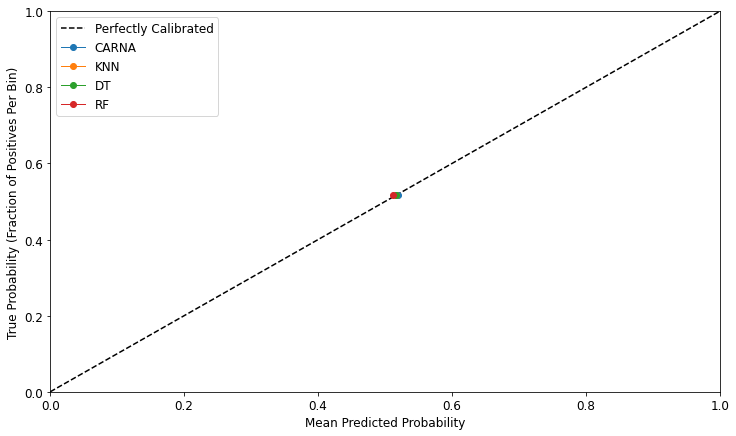

In [21]:
# Calibration Plot - All Data Rehosp - Guide

gt_guide = [0.5118110236220472, 0.5299145299145299, 0.5179856115107914, 0.505338078291815, 0.5714285714285714]

n_bins = 10
binaryLabels = guideLabels['Rehosp']
scoreIdx = guideAllDatarehosp.index
gt = gt_guide
carna_y, carna_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=guideAllDatarehosp, groundTruthProbs=gt)


knnScores = pd.DataFrame(guide_knn_pred, index=scoreIdx)
knn_y, knn_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=knnScores, groundTruthProbs=gt)

dtScores = pd.DataFrame(guide_dt_pred, index=scoreIdx)
dt_y, dt_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=dtScores, groundTruthProbs=gt)

rfScores = pd.DataFrame(guide_rf_pred, index=scoreIdx)
rf_y, rf_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=rfScores, groundTruthProbs=gt)


fig, ax = plt.subplots(figsize=(12,7))
line = mlines.Line2D([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly Calibrated')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

# only these two lines are calibration curves
plt.plot(carna_x, carna_y, marker='o', linewidth=1, label='CARNA')
plt.plot(knn_x, knn_y, marker='o', linewidth=1, label='KNN')
plt.plot(dt_x, dt_y, marker='o', linewidth=1, label='DT')
plt.plot(rf_x, rf_y, marker='o', linewidth=1, label='RF')

# plt.title('Calibration plot for Hemo - DeLvTx')
ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('True Probability (Fraction of Positives Per Bin)')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
plt.legend()

plt.savefig("Figures/Calibration_AllData_Rehosp_Guide.png")
plt.show()

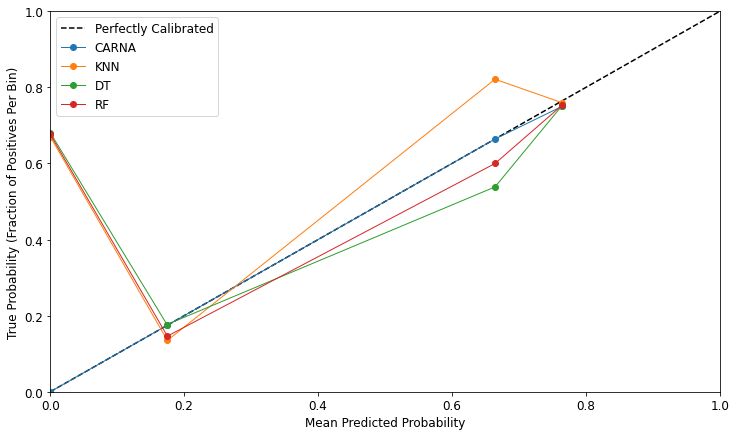

In [22]:
# Calibration Plot - All Data Rehosp - Card Shock

gt_card = [0.175, 0.17307692307692307, 0.0, 0.7643192488262911, 0.6643192488262911]

n_bins = 10
binaryLabels = cardShockLabels['Rehosp']
scoreIdx = cardShockAllDatarehosp.index
gt = gt_card
carna_y, carna_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=cardShockAllDatarehosp, groundTruthProbs=gt)


knnScores = pd.DataFrame(cs_knn_pred, index=scoreIdx)
knn_y, knn_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=knnScores, groundTruthProbs=gt)

dtScores = pd.DataFrame(cs_dt_pred, index=scoreIdx)
dt_y, dt_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=dtScores, groundTruthProbs=gt)

rfScores = pd.DataFrame(cs_rf_pred, index=scoreIdx)
rf_y, rf_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=rfScores, groundTruthProbs=gt)


fig, ax = plt.subplots(figsize=(12,7))
line = mlines.Line2D([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly Calibrated')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

# only these two lines are calibration curves
plt.plot(carna_x, carna_y, marker='o', linewidth=1, label='CARNA')
plt.plot(knn_x, knn_y, marker='o', linewidth=1, label='KNN')
plt.plot(dt_x, dt_y, marker='o', linewidth=1, label='DT')
plt.plot(rf_x, rf_y, marker='o', linewidth=1, label='RF')

# plt.title('Calibration plot for Hemo - DeLvTx')
ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('True Probability (Fraction of Positives Per Bin)')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
plt.legend()

plt.savefig("Figures/Calibration_AllData_Rehosp_CardShock.png")
plt.show()

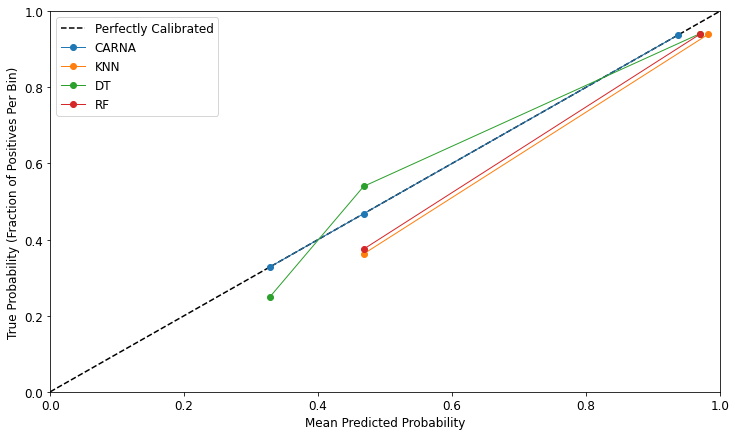

In [23]:
# Calibration Plot - All Data Rehosp - Serial

gt_serial = [0.46808510638297873, 0.3283582089552239, 1.0, 0.9381443298969072, 0.9375]

n_bins = 10
binaryLabels = serialLabels['Rehosp']
scoreIdx = serialAllDatarehosp.index
gt = gt_serial
carna_y, carna_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=serialAllDatarehosp, groundTruthProbs=gt)


knnScores = pd.DataFrame(ser_knn_pred, index=scoreIdx)
knn_y, knn_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=knnScores, groundTruthProbs=gt)

dtScores = pd.DataFrame(ser_dt_pred, index=scoreIdx)
dt_y, dt_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=dtScores, groundTruthProbs=gt)

rfScores = pd.DataFrame(ser_rf_pred, index=scoreIdx)
rf_y, rf_x = getCalibrationCurve(binaryLabels=binaryLabels, predScores=rfScores, groundTruthProbs=gt)


fig, ax = plt.subplots(figsize=(12,7))
line = mlines.Line2D([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly Calibrated')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

# only these two lines are calibration curves
plt.plot(carna_x, carna_y, marker='o', linewidth=1, label='CARNA')
plt.plot(knn_x, knn_y, marker='o', linewidth=1, label='KNN')
plt.plot(dt_x, dt_y, marker='o', linewidth=1, label='DT')
plt.plot(rf_x, rf_y, marker='o', linewidth=1, label='RF')

# plt.title('Calibration plot for Hemo - DeLvTx')
ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('True Probability (Fraction of Positives Per Bin)')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
plt.legend()

plt.savefig("Figures/Calibration_AllData_Rehosp_Serial.png")
plt.show()

## Readm Outcome

In [24]:
xData = copy.deepcopy(escAllData)
yData = escAllDatareadm
xData.shape, yData.shape

# KNN
modelName = "KNN"
knn = KNeighborsClassifier()

knn, knn_train_mets = MC.trainCrossVal(xData, yData, model=knn, numFolds=5, modelName=modelName, showIndividualROC=False)

# DT
modelName = "DT"
dt = DecisionTreeClassifier(random_state=100, max_depth=None)

dt, dt_train_mets = MC.trainCrossVal(xData, yData, model=dt, numFolds=5, modelName=modelName, showIndividualROC=False)


# RF
modelName = "RF"
rf = RandomForestClassifier(random_state=100, n_estimators=1000)

rf, rf_train_mets = MC.trainCrossVal(xData, yData, model=rf, numFolds=5, modelName=modelName, showIndividualROC=False)


metLst = [knn_train_mets, dt_train_mets, rf_train_mets]

# Make dataframe of stats
columns=["Model", "TPR", "TPR SD", "TPR CI", "TNR", "TNR SD", "TNR CI", "PPV", "PPV SD", "PPV CI",
             "NPV", "NPV SD", "NPV CI", "FPR", "FPR SD", "FPR CI", "FNR", "FNR SD", "FNR CI",
             "Acc", "Acc SD", "Acc CI", "AUC", "AUC SD", "AUC CI"]

mets = pd.DataFrame(metLst, columns=columns)
mets.index = ["Escape", 
              "Escape", 
              "Escape"]
mets.to_csv("AllData_Readm_Results.csv")
mets

,Model,TPR,TPR SD,TPR CI,TNR,TNR SD,TNR CI,PPV,PPV SD,PPV CI,...,FPR CI,FNR,FNR SD,FNR CI,Acc,Acc SD,Acc CI,AUC,AUC SD,AUC CI
Escape,KNN,0.459976,0.854248,0.018844,0.820903,0.596033,0.053358,0.562747,0.592467,0.023594,...,0.053358,0.540024,0.854248,0.018844,0.865136,0.293304,0.056917,0.632653,0.388200,0.034306
Escape,DT,0.962260,0.178261,0.064041,0.993664,0.022101,0.066180,0.923021,0.298696,0.061262,...,0.066180,0.037740,0.178261,0.064041,0.992606,0.018353,0.066109,0.977687,0.091280,0.065100
Escape,RF,0.834369,0.603725,0.054466,0.990643,0.037637,0.065977,0.967529,0.171061,0.064405,...,0.065977,0.165631,0.603725,0.054466,0.993531,0.013997,0.066171,0.912099,0.296864,0.060466


In [25]:
# TODO - need to figure out why across different outcome labels a lot of these are the same value ... 
# Potentially try drop NA instead of impute with zeros and infs

# Print out dataframes and compare btw outcomes